
# IMDB Reviews — EDA + Classical Models + BiLSTM Baseline

**Goal.** Analyze the IMDB 50K Reviews dataset with clean EDA, build strong classical baselines (MultinomialNB, Logistic Regression, Linear SVM with calibration), tune decision threshold by F1, explain top terms, and add a BiLSTM as a deep learning baseline.

**Why this notebook?**
- Kaggle-ready: path‑flexible loading, artifacts saving, stable CV.
- No data leakage in explainability.
- Clear visuals and concise summaries.

## Dataset

- **File:** `IMDB Dataset.csv`  
- **Rows:** 50,000 reviews  
- **Columns:**  
  - `review` — movie review text  
  - `sentiment` — label (`positive`/`negative`)

# Setup & Imports

In [1]:

import os, re, string, warnings, math
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("Set2")
plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = (12, 6)

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, roc_auc_score,
    precision_recall_curve, roc_curve, auc, confusion_matrix, classification_report,
    brier_score_loss
)
from sklearn.utils import Bunch
from joblib import dump

SEED = 42
np.random.seed(SEED)

# Artifacts directory
ART_DIR = "/kaggle/working/artifacts" if os.path.exists("/kaggle/working") else "./artifacts"
os.makedirs(ART_DIR, exist_ok=True)
print("Artifacts directory:", ART_DIR)


Artifacts directory: /kaggle/working/artifacts


# Load Dataset 

In [2]:
df = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')


In [3]:
print("Shape:", df.shape)
display(df.head(3))
display(df.sample(3, random_state=SEED))
display(df.dtypes)

Shape: (50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive


,review,sentiment
33553,I really liked this Summerslam due to the look...,positive
9427,Not many television shows appeal to quite as m...,positive
199,The film quickly gets to a major chase scene w...,negative


review       object
sentiment    object
dtype: object

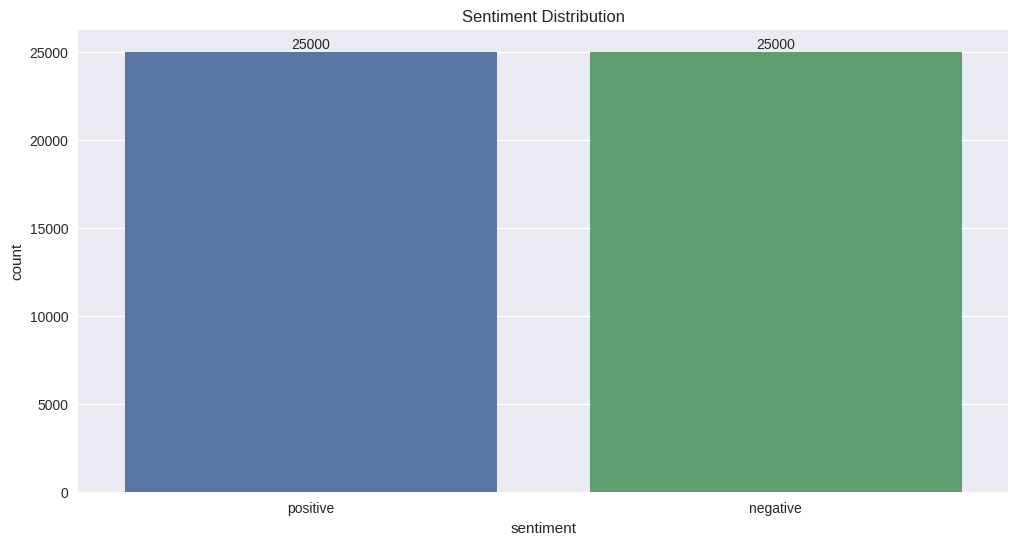

In [4]:
ax = sns.countplot(data=df, x="sentiment")
ax.bar_label(ax.containers[0])
plt.title("Sentiment Distribution")
plt.show()

## Advanced Cleaning Pipeline (Configurable)

Pragmatic defaults for speed, with optional toggles for contractions, stopwords removal, and lemmatization.

# Cleaning

,review,clean_review,sentiment
0,One of the other reviewers has mentioned that ...,one of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,a wonderful little production the filming tech...,positive
2,I thought this was a wonderful way to spend ti...,i thought this was a wonderful way to spend ti...,positive



Example 1:
RAW   : I really liked this Summerslam due to the look of the arena, the curtains and just the look overall was interesting to me for some reason. Anyways, this could have been one of the best Summerslam's ever if the WWF didn't...
CLEAN : i really liked this summerslam due to the look of the arena the curtains and just the look overall was interesting to me for some reason anyways this could have been one of the best summerslams ever if the wwf didnt have...

Example 2:
RAW   : Not many television shows appeal to quite as many different kinds of fans like Farscape does...I know youngsters and 30/40+ years old;fans both Male and Female in as many different countries as you can think of that just...
CLEAN : not many television shows appeal to quite as many different kinds of fans like farscape doesi know youngsters and years oldfans both male and female in as many different countries as you can think of that just adore this...

Example 3:
RAW   : The film quickly gets to a m

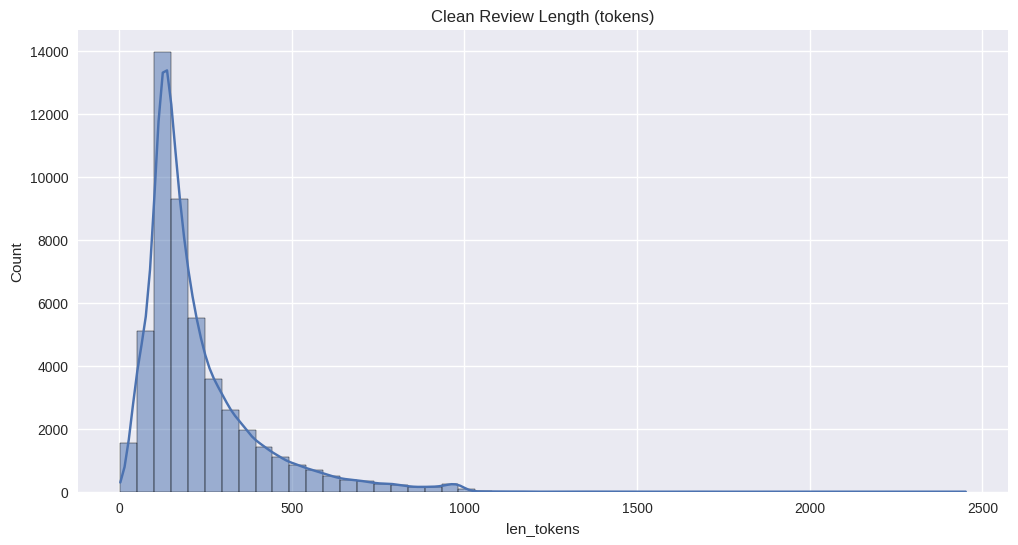

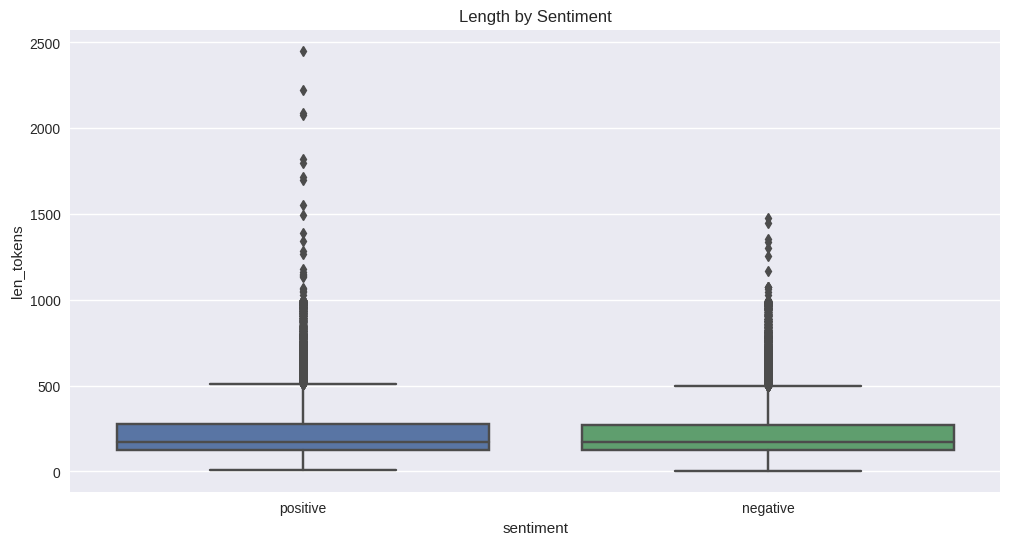

In [5]:
try:
    import contractions
    HAS_CONTRACTIONS = True
except Exception:
    HAS_CONTRACTIONS = False

try:
    import nltk
    from nltk.corpus import stopwords
    from nltk.stem import WordNetLemmatizer
    nltk.download("stopwords", quiet=True)
    nltk.download("wordnet", quiet=True)
    STOPWORDS = set(stopwords.words("english"))
    LEM = WordNetLemmatizer()
    HAS_NLTK = True
except Exception:
    HAS_NLTK = False
    STOPWORDS = set()
    LEM = None

HTML_TAG_RE = re.compile(r"<.*?>")

def clean_text(
    text: str,
    expand_contr: bool = False,
    remove_stop: bool = False,
    lemmatize: bool = False
) -> str:
    if not isinstance(text, str):
        return ""
    if expand_contr and HAS_CONTRACTIONS:
        text = contractions.fix(text)
    text = text.lower()
    text = HTML_TAG_RE.sub(" ", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r"\d+", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    if (remove_stop or lemmatize) and HAS_NLTK:
        tokens = text.split()
        if remove_stop:
            tokens = [t for t in tokens if t not in STOPWORDS]
        if lemmatize and LEM is not None:
            tokens = [LEM.lemmatize(t) for t in tokens]
        text = " ".join(tokens)
    return text

# Default: light cleaning
df["clean_review"] = df["review"].apply(lambda t: clean_text(t, expand_contr=False, remove_stop=False, lemmatize=False))

# Simple length features
df["len_tokens"] = df["clean_review"].str.split().apply(lambda x: len(x) if isinstance(x, list) else 0)
df["len_chars"]  = df["clean_review"].str.len()

display(df[["review","clean_review","sentiment"]].head(3))

# Before vs After (small peek)
sample_idx = np.random.choice(len(df), size=3, replace=False)
for i, idx in enumerate(sample_idx, 1):
    raw = df.loc[idx, "review"]
    cln = df.loc[idx, "clean_review"]
    print(f"\nExample {i}:")
    print("RAW   :", (raw[:220] + "...") if len(raw) > 220 else raw)
    print("CLEAN :", (cln[:220] + "...") if len(cln) > 220 else cln)

sns.histplot(df["len_tokens"], bins=50, kde=True)
plt.title("Clean Review Length (tokens)")
plt.show()

sns.boxplot(data=df, x="sentiment", y="len_tokens")
plt.title("Length by Sentiment")
plt.show()

# Top N-grams

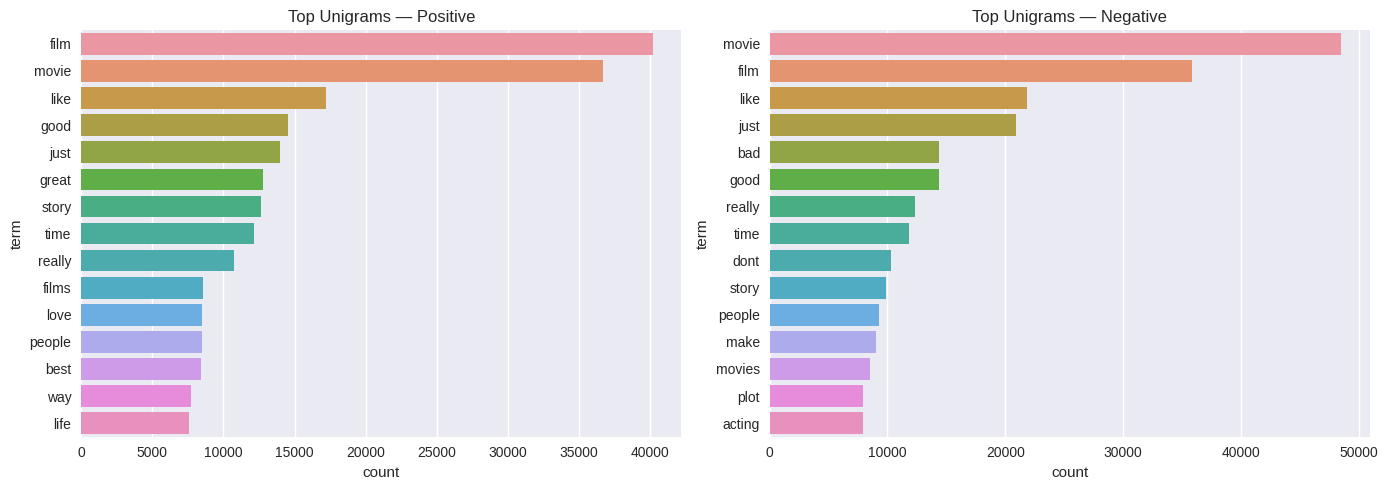

In [6]:
def top_ngrams(corpus, ngram_range=(1,1), top_k=15, min_df=5, max_df=0.9):
    vec = CountVectorizer(ngram_range=ngram_range, min_df=min_df, max_df=max_df, stop_words="english")
    X = vec.fit_transform(corpus)
    total = np.asarray(X.sum(axis=0)).ravel()
    vocab = np.array(vec.get_feature_names_out())
    idx = np.argsort(total)[::-1][:top_k]
    return pd.DataFrame({"term": vocab[idx], "count": total[idx]})

fig, axes = plt.subplots(1, 2, figsize=(14,5))
pos_uni = top_ngrams(df.loc[df.sentiment=="positive","clean_review"], (1,1))
neg_uni = top_ngrams(df.loc[df.sentiment=="negative","clean_review"], (1,1))
sns.barplot(data=pos_uni, x="count", y="term", ax=axes[0])
axes[0].set_title("Top Unigrams — Positive")
sns.barplot(data=neg_uni, x="count", y="term", ax=axes[1])
axes[1].set_title("Top Unigrams — Negative")
plt.tight_layout(); plt.show()

## Train/Test + Vectorization

In [7]:
X = df["clean_review"].astype(str).values
y = df["sentiment"].astype(str).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

tfidf = TfidfVectorizer(max_features=60000, ngram_range=(1,2), min_df=3, max_df=0.9, stop_words="english", dtype=np.float32)
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec  = tfidf.transform(X_test)

print("Train shape:", X_train_vec.shape, " Test shape:", X_test_vec.shape)

Train shape: (40000, 60000)  Test shape: (10000, 60000)


# Classical Models + Stratified CV 

In [8]:
base_models = {
    "MultinomialNB": MultinomialNB(),
    "LogisticRegression": LogisticRegression(max_iter=1000, solver="liblinear", random_state=SEED),
    "LinearSVM(calibrated)": CalibratedClassifierCV(LinearSVC(random_state=SEED), cv=3, method="sigmoid")
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# Use binary labels for roc_auc inside CV
y_train_bin_cv = (y_train == "positive").astype(int)

cv_rows = []
for name, mdl in base_models.items():
    scoring = {"acc": "accuracy", "f1": "f1", "roc": "roc_auc"}
    scores = cross_validate(
        mdl, X_train_vec, y_train_bin_cv, cv=skf,
        scoring=scoring, n_jobs=-1, return_train_score=False
    )
    cv_rows.append({
        "model": name,
        "cv_acc_mean": scores["test_acc"].mean(),
        "cv_acc_std":  scores["test_acc"].std(),
        "cv_f1_mean":  scores["test_f1"].mean(),
        "cv_roc_mean": scores["test_roc"].mean()
    })

cv_df = pd.DataFrame(cv_rows).sort_values("cv_f1_mean", ascending=False).reset_index(drop=True)
display(cv_df.style.format({
    "cv_acc_mean":"{:.4f}","cv_acc_std":"{:.4f}",
    "cv_f1_mean":"{:.4f}","cv_roc_mean":"{:.4f}"
}))

,model,cv_acc_mean,cv_acc_std,cv_f1_mean,cv_roc_mean
0,LinearSVM(calibrated),0.8983,0.0039,0.8990,0.9626
1,LogisticRegression,0.8921,0.0025,0.8936,0.9594
2,MultinomialNB,0.8741,0.0021,0.8745,0.9462


# Fit & Evaluate on Holdout

In [9]:
def evaluate(model, Xtr, ytr, Xte, yte) -> Bunch:
    model.fit(Xtr, ytr)
    pred = model.predict(Xte)
    acc = accuracy_score(yte, pred)
    prec, rec, f1, _ = precision_recall_fscore_support(yte, pred, average="binary", pos_label="positive")
    if hasattr(model, "predict_proba"):
        scores = model.predict_proba(Xte)[:,1]
    elif hasattr(model, "decision_function"):
        scores = model.decision_function(Xte)
    else:
        scores = (pred=="positive").astype(float)
    y_true_bin = (yte=="positive").astype(int)
    try:
        roc = roc_auc_score(y_true_bin, scores)
    except Exception:
        roc = np.nan
    p, r, th = precision_recall_curve(y_true_bin, scores)
    pr_auc = auc(r, p)
    return Bunch(model=model, pred=pred, scores=scores, acc=acc, prec=prec, rec=rec, f1=f1, roc_auc=roc, pr_auc=pr_auc, pr_curve=(p,r,th))

results = {name: evaluate(mdl, X_train_vec, y_train, X_test_vec, y_test) for name, mdl in base_models.items()}

summary = pd.DataFrame({
    "model": list(results.keys()),
    "accuracy": [results[k].acc for k in results],
    "precision_pos": [results[k].prec for k in results],
    "recall_pos": [results[k].rec for k in results],
    "f1_pos": [results[k].f1 for k in results],
    "roc_auc": [results[k].roc_auc for k in results],
    "pr_auc": [results[k].pr_auc for k in results],
}).sort_values(by=["f1_pos","roc_auc","pr_auc"], ascending=False).reset_index(drop=True)
display(summary.style.format({c:"{:.4f}" for c in summary.columns if c!="model"}))

best_name = summary.loc[0, "model"]
best = results[best_name]
print(f"Best: {best_name} | Acc={best.acc:.4f} | F1={best.f1:.4f} | ROC-AUC={best.roc_auc:.4f} | AP={best.pr_auc:.4f}")

# Save results table to artifacts
summary.to_csv(os.path.join(ART_DIR, "model_summary.csv"), index=False)
print("Saved summary to:", os.path.join(ART_DIR, "model_summary.csv"))

,model,accuracy,precision_pos,recall_pos,f1_pos,roc_auc,pr_auc
0,LinearSVM(calibrated),0.9078,0.9025,0.9144,0.9084,0.9668,0.9660
1,LogisticRegression,0.9009,0.8931,0.9108,0.9019,0.9636,0.9627
2,MultinomialNB,0.8794,0.8749,0.8854,0.8801,0.9478,0.9473


Best: LinearSVM(calibrated) | Acc=0.9078 | F1=0.9084 | ROC-AUC=0.9668 | AP=0.9660
Saved summary to: /kaggle/working/artifacts/model_summary.csv


# ROC & PR + Confusion

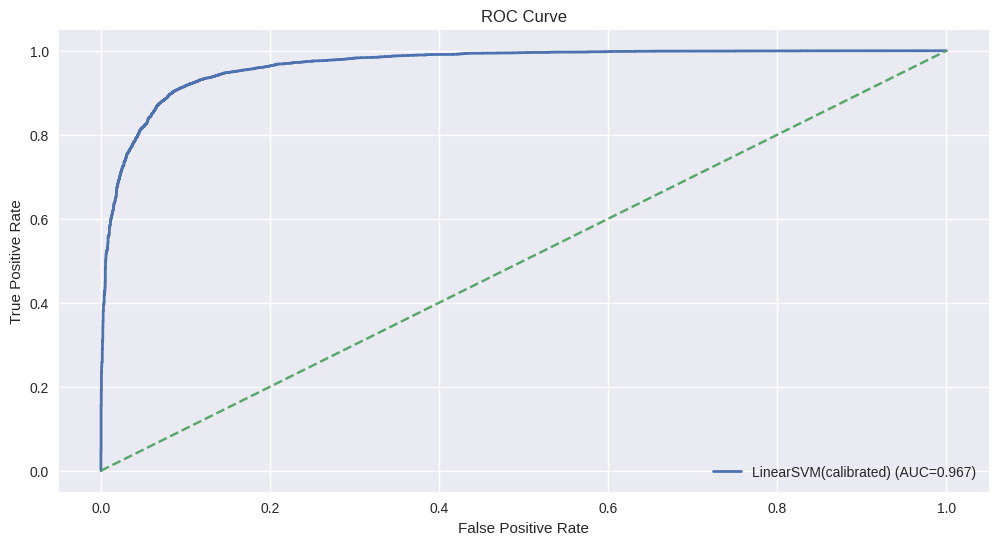

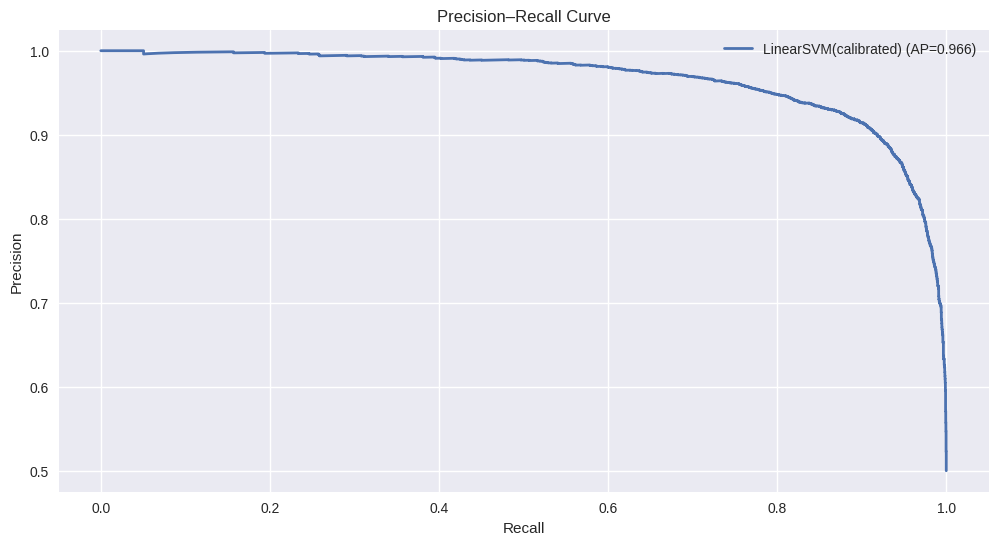

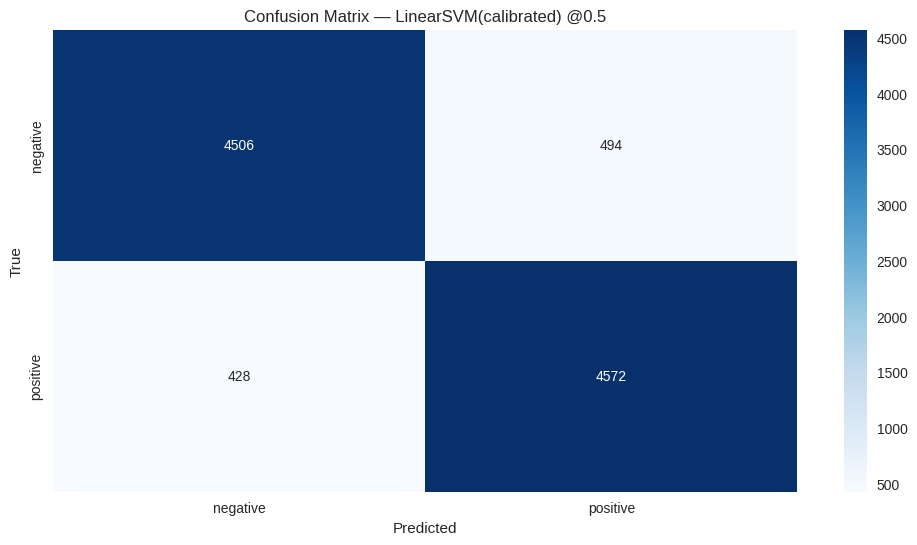

In [10]:
y_true_bin = (y_test=="positive").astype(int)

# ROC
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
fpr, tpr, _ = roc_curve(y_true_bin, best.scores)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, label=f"{best_name} (AUC={roc_auc:.3f})")
plt.plot([0,1],[0,1],"--")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve"); plt.legend(); plt.show()

# PR
prec, rec, th = precision_recall_curve(y_true_bin, best.scores)
pr_auc = auc(rec, prec)
plt.plot(rec, prec, lw=2, label=f"{best_name} (AP={pr_auc:.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision–Recall Curve"); plt.legend(); plt.show()

# Confusion @ default 0.5
pred_label = best.pred
cm = confusion_matrix(y_test, pred_label, labels=["negative","positive"])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["negative","positive"], yticklabels=["negative","positive"])
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title(f"Confusion Matrix — {best_name} @0.5"); plt.show()

# Calibration Curve & Brier Score

Brier score (lower is better): 0.0701


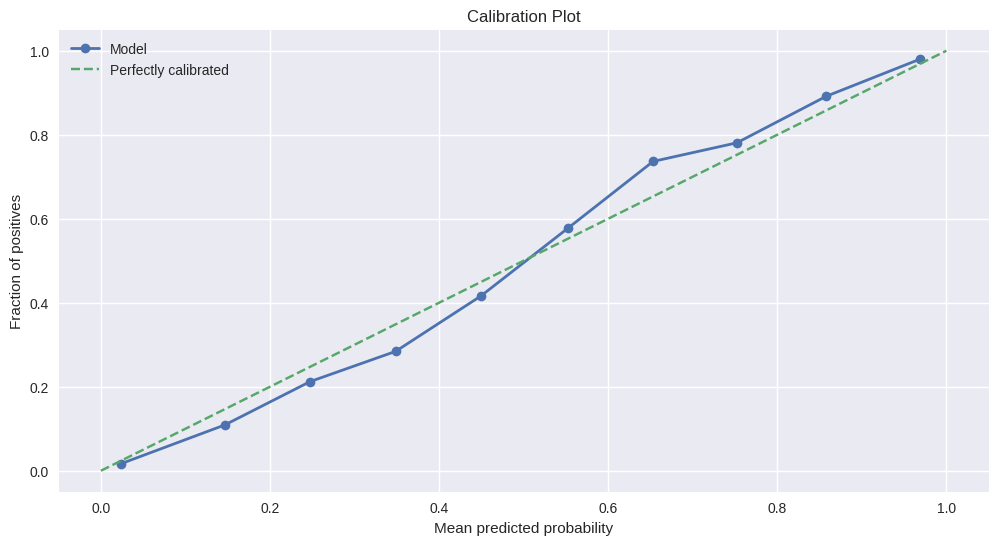

In [11]:

# Compute Brier score if probabilities exist
from sklearn.calibration import calibration_curve

if hasattr(best.model, "predict_proba") or hasattr(best.model, "decision_function"):
    # Use scores already computed
    prob_pos = best.scores if np.max(best.scores)<=1.0 and np.min(best.scores)>=0.0 else (best.scores - best.scores.min())/(best.scores.max()-best.scores.min() + 1e-9)
    bs = brier_score_loss(y_true_bin, prob_pos)
    print(f"Brier score (lower is better): {bs:.4f}")

    frac_pos, mean_pred = calibration_curve(y_true_bin, prob_pos, n_bins=10, strategy="uniform")
    plt.plot(mean_pred, frac_pos, marker="o", linewidth=2, label="Model")
    plt.plot([0,1],[0,1], "--", label="Perfectly calibrated")
    plt.xlabel("Mean predicted probability"); plt.ylabel("Fraction of positives")
    plt.title("Calibration Plot")
    plt.legend(); plt.show()
else:
    print("Calibration skipped: model does not expose scores.")


# Threshold Tuning by F1 

Best threshold by F1: 0.476 (F1=0.909)
              precision    recall  f1-score   support

    negative       0.92      0.90      0.91      5000
    positive       0.90      0.92      0.91      5000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



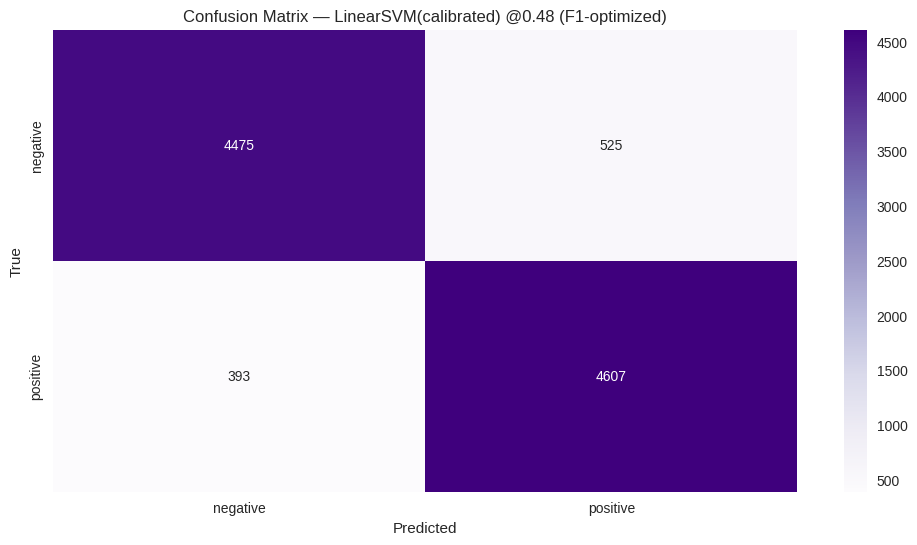

In [12]:
prec, rec, th = best.pr_curve
f1_vals = 2 * (prec[:-1] * rec[:-1]) / (prec[:-1] + rec[:-1] + 1e-9)
best_idx = np.nanargmax(f1_vals)
best_th = th[best_idx]
best_f1 = f1_vals[best_idx]
print(f"Best threshold by F1: {best_th:.3f} (F1={best_f1:.3f})")

y_pred_th = (best.scores >= best_th).astype(int)
y_labels_th = np.where(y_pred_th==1, "positive", "negative")
print(classification_report(y_test, y_labels_th, labels=["negative","positive"]))

cm_th = confusion_matrix(y_test, y_labels_th, labels=["negative","positive"])
sns.heatmap(cm_th, annot=True, fmt="d", cmap="Purples", xticklabels=["negative","positive"], yticklabels=["negative","positive"])
plt.title(f"Confusion Matrix — {best_name} @{best_th:.2f} (F1‑optimized)")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.show()

# Model Explainability — (Logistic) WITHOUT leakage

,term,weight
0,great,8.629788
1,excellent,7.523553
2,best,6.189272
3,perfect,5.593703
4,amazing,5.402923
5,wonderful,5.251597
6,loved,4.939641
7,fun,4.767627
8,favorite,4.613303
9,enjoyed,4.511610


,term,weight
0,worst,-10.478180
1,bad,-9.119365
2,awful,-8.109138
3,waste,-7.284430
4,boring,-7.070569
5,poor,-6.270089
6,terrible,-6.123215
7,worse,-5.601589
8,dull,-5.223192
9,horrible,-5.141127


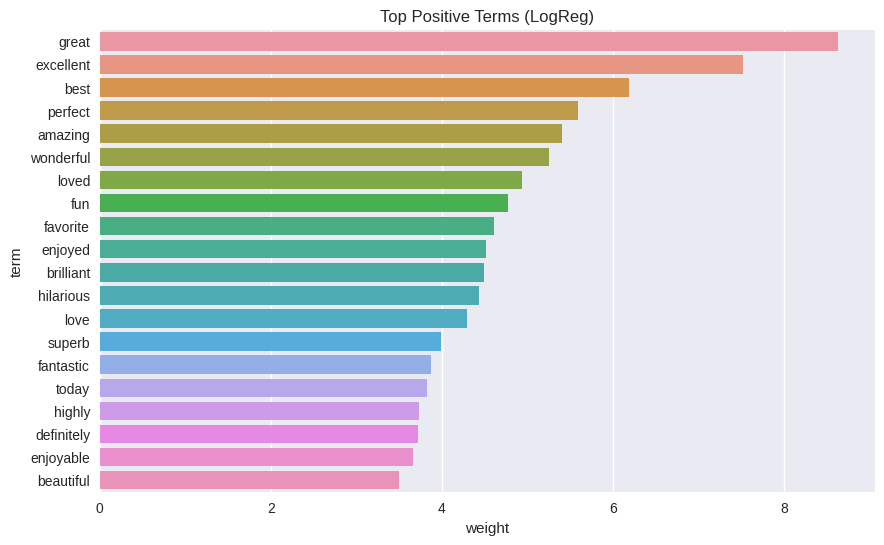

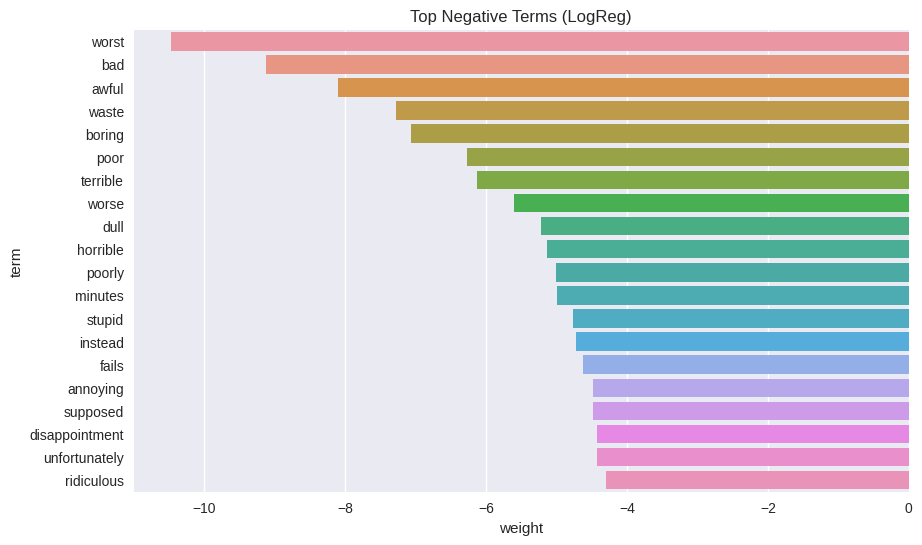

In [13]:
if "LogisticRegression" in [k.split("(")[0] for k in results.keys()]:
    lr_model = results["LogisticRegression"].model  # trained on train only
    feats = np.array(tfidf.get_feature_names_out())
    coefs = lr_model.coef_[0]
    k = 20
    top_pos_idx = np.argsort(coefs)[-k:][::-1]
    top_neg_idx = np.argsort(coefs)[:k]
    top_pos = pd.DataFrame({"term": feats[top_pos_idx], "weight": coefs[top_pos_idx]})
    top_neg = pd.DataFrame({"term": feats[top_neg_idx], "weight": coefs[top_neg_idx]})
    display(top_pos); display(top_neg)

    plt.figure(figsize=(10,6)); sns.barplot(data=top_pos, x="weight", y="term"); plt.title("Top Positive Terms (LogReg)"); plt.show()
    plt.figure(figsize=(10,6)); sns.barplot(data=top_neg, x="weight", y="term"); plt.title("Top Negative Terms (LogReg)"); plt.show()
else:
    print("Logistic Regression not present — skipping coefficient view.")

# Error analysis (top FP/FN)

In [14]:

test_df = pd.DataFrame({"text": X_test, "true": y_test, "score": best.scores})
pred_def = best.pred
pred_opt = np.where(test_df["score"]>=best_th, "positive", "negative")

fp = test_df[(test_df["true"]=="negative") & (pred_def=="positive")].sort_values("score", ascending=False).head(5)
fn = test_df[(test_df["true"]=="positive") & (pred_def=="negative")].sort_values("score", ascending=True).head(5)

print("\nFalse Positives (default @0.5):")
for _, r in fp.iterrows():
    text_clean = r['text'][:220].replace("\n", " ")
    print(f"- score={r['score']:.3f} | {text_clean}...")

print("\nFalse Negatives (default @0.5):")
for _, r in fn.iterrows():
    text_clean = r['text'][:220].replace("\n", " ")
    print(f"- score={r['score']:.3f} | {text_clean}...")



False Positives (default @0.5):
- score=0.998 | this sleek sexy movie is a mustsee only upon multiple viewings can one truly understand the uniqueness of this film personally i enjoy the narrator for his intelligent no subject left untouched style of narration the int...
- score=0.992 | great movie especially the music etta james at last this speaks volumes when you have finally found that special someone...
- score=0.989 | even thought im not the biggest of cher fans this movie was her crowning achievement granted there were long term sideeffects and risks of brain damage memory loss and intellectual impairment upon the screening such a fi...
- score=0.986 | i saw winnies heffalump a couple of days ago a nice story based on well known characters created by aamilne although winnie piglet tigger and rabbit are all present in this animated feature the main character is roo this...
- score=0.985 | this film is worth seeing since it is a classic in the sense of being the very first full l

# BiLSTM with simple curves

2025-09-16 14:37:17.976536: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758033438.324311      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758033438.420284      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Epoch 1/2


I0000 00:00:1758033464.736918      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758033464.737614      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


141/141 ━━━━━━━━━━━━━━━━━━━━ 104s 639ms/step - accuracy: 0.6144 - loss: 0.6305 - val_accuracy: 0.8455 - val_loss: 0.3626
Epoch 2/2
141/141 ━━━━━━━━━━━━━━━━━━━━ 89s 632ms/step - accuracy: 0.8512 - loss: 0.3650 - val_accuracy: 0.8590 - val_loss: 0.3394


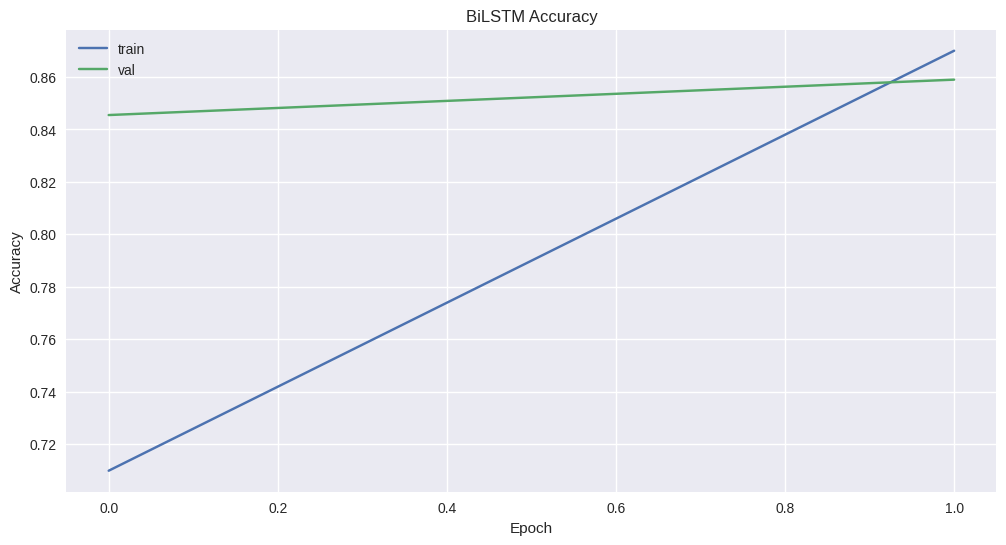

BiLSTM Accuracy: 0.855400025844574


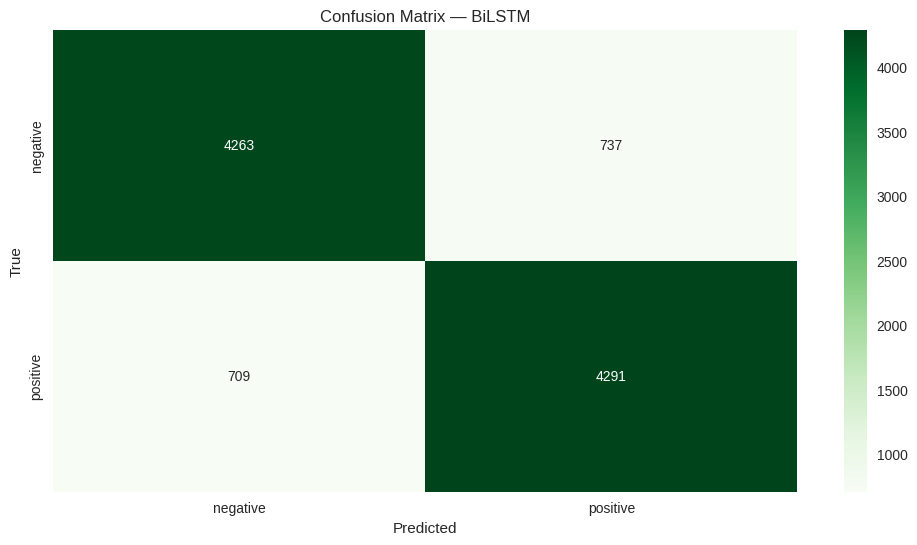

In [15]:
try:
    # ===== Imports =====

    import tensorflow as tf
    from tensorflow.keras.preprocessing.text import Tokenizer
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
    from sklearn.preprocessing import LabelEncoder
    from tensorflow.keras.utils import to_categorical

    tf.keras.utils.set_random_seed(42)

    MAX_WORDS = 30000
    MAX_LEN   = 150

    # ===== Tokenize & Pad =====
    tok = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
    tok.fit_on_texts(X_train)
    Xtr = pad_sequences(tok.texts_to_sequences(X_train), maxlen=MAX_LEN, padding="post", truncating="post")
    Xte = pad_sequences(tok.texts_to_sequences(X_test),  maxlen=MAX_LEN, padding="post", truncating="post")

    # ===== Labels =====
    le = LabelEncoder()
    ytr = to_categorical(le.fit_transform(y_train))
    yte = to_categorical(le.transform(y_test))

    # ===== Model =====
    model = Sequential([
        Embedding(input_dim=MAX_WORDS, output_dim=128, input_length=MAX_LEN),
        Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)),
        Dropout(0.3),
        Dense(64, activation="relu"),
        Dropout(0.3),
        Dense(2, activation="softmax")
    ])
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

    history = model.fit(
        Xtr, ytr,
        validation_split=0.1,
        epochs=2,
        batch_size=256,
        verbose=1
    )

    # ===== Curves =====
    plt.figure()
    plt.plot(history.history["accuracy"], label="train")
    plt.plot(history.history["val_accuracy"], label="val")
    plt.title("BiLSTM Accuracy")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend()
    plt.show()

    # ===== Evaluate =====
    loss, acc = model.evaluate(Xte, yte, verbose=0)
    print("BiLSTM Accuracy:", acc)

    # ===== Confusion Matrix =====
    y_prob = model.predict(Xte, verbose=0)             
    y_pred_idx = y_prob.argmax(axis=1)               
    y_true_idx = yte.argmax(axis=1)                   

    lbls = le.inverse_transform([0, 1])              
    cm_dl = confusion_matrix(y_true_idx, y_pred_idx)

    plt.figure()
    sns.heatmap(cm_dl, annot=True, fmt="d", cmap="Greens",
                xticklabels=lbls, yticklabels=lbls)
    plt.title("Confusion Matrix — BiLSTM")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.show()

except Exception as e:
    print("BiLSTM section skipped (env issue). Classical models are already strong for cost on IMDB. Error:", e)


# Save Artifacts

In [16]:
dump(tfidf, os.path.join(ART_DIR, "tfidf_vectorizer.joblib"))
dump(best.model, os.path.join(ART_DIR, f"{best_name.replace(' ','_').lower()}_model.joblib"))
print("Saved artifacts to:", ART_DIR)

Saved artifacts to: /kaggle/working/artifacts



##  Summary & Next Steps

**You got**
- Clean EDA with n‑grams (and optional wordclouds if you add them)
- Strong classical baselines with **Stratified 5‑Fold CV**
- ROC/PR curves and **F1‑optimized thresholding**
- Calibration plot + Brier score
- Model Explainability — (Logistic) WITHOUT leakage
- Error analysis (top FP/FN)
- BiLSTM with simple curves